# Datamining the Protein Data Bank with mmtf-pyspark

Mmtf-pyspark is a framework for the interactive mining of the Protein Data Bank (PDB). As an example, this demo analyzes the environment around zinc ions in proteins.

This example demonstrates how to:
    
* Configure pyspark
* Read PDB structures in MMTF file format
* Find zinc interactions with mmtf-pyspark
* Show results in spark dataframes and pandas
* Visualize structures in 3D
* Plot results

For more example notebooks see the [demos folder](./demos).

In [1]:
from pyspark.sql import SparkSession                   
from mmtfPyspark.io import mmtfReader                                
from mmtfPyspark.webfilters import Pisces                        
from mmtfPyspark.datasets import groupInteractionExtractor
from mmtfPyspark.structureViewer import view_group_interaction
import pandas as pd

## Configure Spark
Setup pyspark to run locally on 4 cores.

In [2]:
spark = SparkSession.builder.master("local[4]").appName("Demo").getOrCreate()

## Read PDB structures
Read a provided sample (~10,000 structures) of the PDB in MMTF format (https://mmtf.rcsb.org).

In [3]:
path = "./resources/mmtf_full_sample/"
pdb = mmtfReader.read_sequence_file(path)

## Create a non-redundant subset
Create a Pisces (Protein Sequence Culling Server, http://dunbrack.fccc.edu/PISCES.php) non-redundant subset for this analysis. Select protein chains with less than 20% sequence identity among each other and a resolution of 2.0 A or better.

In [4]:
pdb = pdb.filter(Pisces(sequenceIdentity = 20, resolution = 2.0))  

## Extract Zinc interactions
Find interactions within 3 A around each zinc and show 10 interactions in a dataframe.

In [5]:
finder = groupInteractionExtractor('ZN', distance = 3.0)       
interactions = finder.get_dataset(pdb)

interactions.show(10)

+-----------+--------+-----+--------+------+--------+-----+--------+------+---------+
|structureId|residue1|atom1|element1|index1|residue2|atom2|element2|index2| distance|
+-----------+--------+-----+--------+------+--------+-----+--------+------+---------+
|       1HFE|      ZN|   ZN|      Zn|   978|     HIS|  CE1|       C|    46|2.1662953|
|       1HFE|      ZN|   ZN|      Zn|   978|     ASP|   CG|       C|    50|2.8161302|
|       1HFE|      ZN|   ZN|      Zn|   978|     ASP|  OD2|       O|    50|1.9296358|
|       1HFE|      ZN|   ZN|      Zn|   978|     HIS|  CD2|       C|   531|2.9568312|
|       1HFE|      ZN|   ZN|      Zn|   978|     HIS|  NE2|       N|   531|2.1217477|
|       1HFE|      ZN|   ZN|      Zn|   978|     ASP|   CG|       C|   535|2.8353317|
|       1HFE|      ZN|   ZN|      Zn|   978|     ASP|  OD2|       O|   535|1.9745901|
|       4N4F|      ZN|   ZN|      Zn|   197|     CYS|   SG|       S|   118|2.3287177|
|       4N4F|      ZN|   ZN|      Zn|   197|     CYS| 

## Get list of unique PDB Ids

In [6]:
# Extract list of PDB Ids from dataframe
pdbIds = [row.structureId for row in interactions.collect()]

# Get unique PDB Ids and convert back to list
unique_pdbIds = list(set(pdbIds))

## Visualize hits
Browse through the list by moving the slider. Note, run the notebook all the way to the end, before moving the slider.

In [7]:
view_group_interaction(unique_pdbIds, 'ZN', style = 'stick');

interactive(children=(IntSlider(value=0, continuous_update=False, description='Structure', max=399), Output())…

## Show top 10 interacting groups  
Determine the most common groups that interact with zinc in proteins. Interactions with carbon are ignored. To show the data, we convert the dataframe to Pandas to create a well-formated table.


In [8]:
df = interactions.filter("element2 != 'C'")\
                 .groupBy("residue2")\
                 .count()\
                 .sort("count", ascending=False)\
                 .toPandas()
df.head(10)

,residue2,count
0,CYS,1115
1,HIS,998
2,HOH,816
3,GLU,630
4,ASP,565
5,ACT,66
6,CAC,43
7,ZN,36
8,CL,36
9,PO4,26


## Plot histogram for top 10 interacting groups

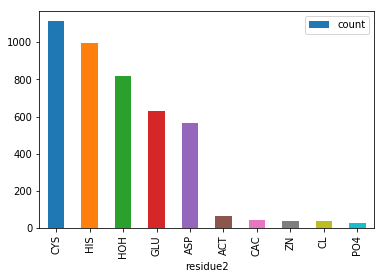

In [9]:
df.head(10).plot(x='residue2', y='count', kind='bar');

## Stop spark
Always run the notebook to the end to stop spark!

In [10]:
spark.stop()